In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing,model_selection,feature_extraction,feature_selection
from collections import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.svm import LinearSVR,SVR
from sklearn.decomposition import PCA
from CategoricalEncoder import *
%matplotlib inline

# Specific functions to manipulate the data:
- Select columns from dataframe
- Perform Likelihood Category Encoding
- Create list of permutations which is used to combine text columns

In [2]:
# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=0,
                  noise_level=0):

    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

def combinations(n, k):
    def directed_combinations(offset, partial_combination):
        if len(partial_combination) == k: 
            result.append(list(partial_combination)) 
            return
        # Generate remaining combinations over {offset, ... , n - 1} of size # num_remaining.
        num_remaining = k - len(partial_combination)
        i = offset
        while i <= n and num_remaining <= n - i + 1: 
            directed_combinations(i+1,partial_combination+ [i]) 
            i += 1
    result= []
    directed_combinations (1, []) 
    return result
def txt_combinations(data,L):
    data['_'.join(data.columns[L])] = data.iloc[:,L].apply(lambda x:'_'.join(x),axis=1)
    return data

# Read the Data

In [3]:
data = pd.read_csv('data/train_features_2013-03-07.csv')
target = pd.read_csv('data/train_salaries_2013-03-07.csv')
data.drop('jobId',axis=1,inplace=True)

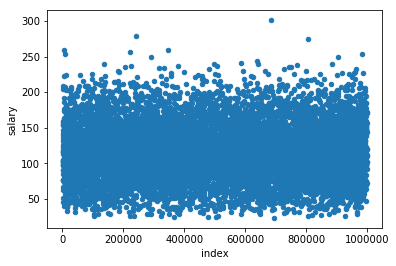

In [4]:
target.sample(10000).reset_index().plot(kind='scatter',x='index', y='salary')

## Very few values are too high or too low. We filter results based on 1% and 99% which substantially shrinks range of tanget.

In [5]:
target.describe(percentiles=[0.01,0.99])

,salary
count,1000000.000000
mean,116.061818
std,38.717936
min,0.000000
1%,39.000000
50%,114.000000
99%,215.000000
max,301.000000


In [6]:
data =  data.loc[((target.salary!=0) & (target.salary<215) & (target.salary>39)),:]
target= target.loc[(target.salary!=0) & (target.salary<215) & (target.salary>39),:]

In [7]:
target.shape

(978985, 2)

## Create combination of categorical feature as new features. This will be helpful in part because of likelihood encoding that is performed in the following steps.

In [8]:
for i in range(1,2):
    for L in combinations(5,i+1):
        print(list(map(lambda x: x-1, L)))
        data = txt_combinations(data,list(map(lambda x: x-1, L)))

[0, 1]
[0, 2]
[0, 3]
[0, 4]
[1, 2]
[1, 3]
[1, 4]
[2, 3]
[2, 4]
[3, 4]


## Splitting data to train, test and validation sets and applying liklihood encoding. 

In [9]:
def catfeats(df):
    return [df.columns[i] for i in range(df.shape[1]) if (df.dtypes[i]=='object')]
def dataframe_encode(dflikhx, df, dflikhy):
    f_cats = catfeats(df)
    for f in f_cats:
        dflikhx[f+'avg'], df[f]= target_encode(dflikhx[f], 
                             df[f], 
                             target=dflikhy.salary)
    return dflikhx,df

trainxtmp, trainlikelihoodx = train_test_split(data,test_size=0.5, random_state=42)
trainytmp, trainlikelihoody = train_test_split(target,test_size=0.5, random_state=42)

trainlikelihoodx,trainxtmp = dataframe_encode(trainlikelihoodx, trainxtmp,trainlikelihoody)

trainx1, testx1 = train_test_split(trainxtmp,test_size=0.5, random_state=42)
trainy1, testy1 = train_test_split(trainytmp,test_size=0.5, random_state=42)






/Users/alizaf/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
trainlikelihoodx.shape

(489493, 32)

## Pipeline to perform the entire prior steps

In [11]:
num_cols = [trainx1.columns[i] for i in range(trainx1.shape[1]) if trainx1.dtypes[i]!='object']
cat_cols = catfeats(trainx1)
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_cols)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_cols)),
#         ('std_scaler', StandardScaler()),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
#         ("cat_pipeline", cat_pipeline)
    ])


In [12]:
xtrain1 = full_pipeline.fit_transform(trainx1)
ytrain1 = trainy1.salary.values
xtest1 = full_pipeline.fit_transform(testx1)
ytest1 = testy1.salary.values

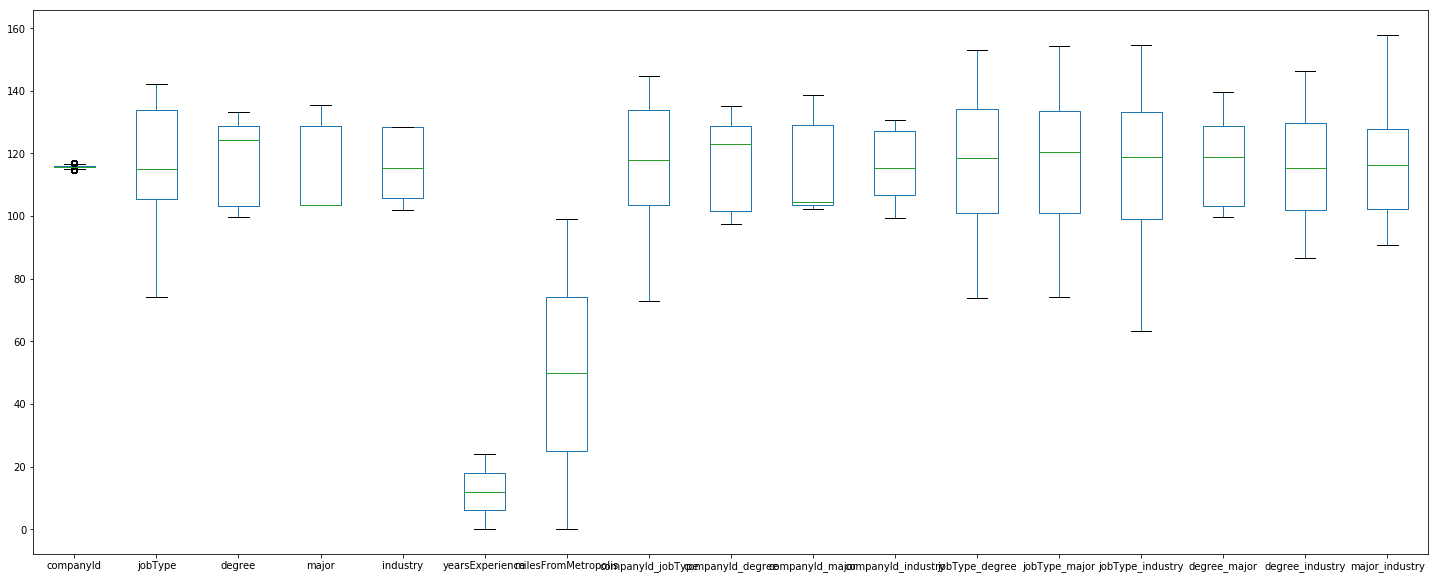

In [13]:
trainxtmp.plot(kind='box',figsize=(25,10))

In [14]:
trainx1.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,companyId_jobType,companyId_degree,companyId_major,companyId_industry,jobType_degree,jobType_major,jobType_industry,degree_major,degree_industry,major_industry
125030,115.948225,95.665224,133.229287,127.536569,105.867027,1,78,96.166488,133.501110,129.695931,106.719745,108.347311,101.632062,84.253418,132.157633,122.773373,116.205036
796762,116.633125,124.631792,128.758814,127.536569,109.990773,6,63,126.220041,129.605378,127.160256,110.877704,131.969205,131.060731,118.664198,127.549034,122.768062,119.446517
767396,115.097906,133.793507,124.137450,130.069178,128.436059,8,76,133.390116,123.902273,129.779510,128.418562,136.847863,142.781189,146.908742,125.282627,138.107420,143.266717
118599,115.847129,133.793507,103.147132,103.677162,109.990773,0,60,133.723969,103.346409,104.191895,109.044658,125.371181,124.723276,128.414918,103.147132,97.327355,98.092578
78745,115.659682,74.073237,103.147132,103.677162,101.823548,21,20,73.388137,102.968004,103.279485,101.477048,74.240209,74.073237,63.317110,103.147132,90.371670,90.630345


## Add polynomial features and scale the features

In [15]:
poly_features = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
xtrpoly = poly_features.fit_transform(xtrain1)
xtspoly = poly_features.fit_transform(xtest1)
# ss = StandardScaler()
ss = MinMaxScaler()
xtrpolyss= ss.fit_transform(xtrpoly)
xtspolyss= ss.fit_transform(xtspoly)
xtrpolyss.shape


(244746, 170)

## Cross validate SVM model

In [16]:
svm_reg = LinearSVR(epsilon=2, random_state=42,loss='squared_epsilon_insensitive')
scores = cross_val_score(svm_reg, xtrpolyss, ytrain1,scoring="neg_mean_squared_error", cv=3)


In [17]:
svm_rmse_scores = np.sqrt(-scores)
print(svm_rmse_scores)

[ 18.40332691  18.50699585  18.44986876]


In [18]:
svm_reg_train = LinearSVR(epsilon=2, random_state=42,loss='squared_epsilon_insensitive')
svm_reg_train.fit(xtrpolyss,ytrain1)

LinearSVR(C=1.0, dual=True, epsilon=2, fit_intercept=True,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=1000, random_state=42, tol=0.0001, verbose=0)

In [19]:
salary_pred = svm_reg_train.predict(xtspolyss)
lin_mse = mean_squared_error(ytest1, salary_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

18.440595602347972

In [20]:
pd.DataFrame(salary_pred).describe()

,0
count,244746.000000
mean,115.855404
std,31.278505
min,29.676479
25%,93.999924
50%,117.059898
75%,138.434556
max,219.605034


## Create final train set based on complete training data (except for the peice we used for encoding) and train the final model

In [21]:
xtrain = np.concatenate([xtspolyss,xtrpolyss])
ytrain = np.concatenate([ytest1,ytrain1])

In [22]:
svm_reg_final = LinearSVR(epsilon=2, random_state=42,loss='squared_epsilon_insensitive')
svm_reg_final.fit(xtrain,ytrain)

LinearSVR(C=1.0, dual=True, epsilon=2, fit_intercept=True,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=1000, random_state=42, tol=0.0001, verbose=0)

In [23]:
salary_pred_valid = svm_reg_final.predict(xtspolyss)
lin_mse = mean_squared_error(ytest1, salary_pred_valid)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

18.436046879526401

## Prepare test data, predict salary and save output in proper format

In [24]:
testdf = pd.read_csv('data/test_features_2013-03-07.csv')
testdf.drop('jobId',axis=1,inplace=True)

In [25]:
for i in range(1,2):
    for L in combinations(5,i+1):
        print(list(map(lambda x: x-1, L)))
        testdf = txt_combinations(testdf,list(map(lambda x: x-1, L)))

[0, 1]
[0, 2]
[0, 3]
[0, 4]
[1, 2]
[1, 3]
[1, 4]
[2, 3]
[2, 4]
[3, 4]


In [26]:
trainlikelihoodx,testdf = dataframe_encode(trainlikelihoodx, testdf,trainlikelihoody)

/Users/alizaf/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
xtest = full_pipeline.fit_transform(testdf)

In [28]:
xtestpoly = poly_features.fit_transform(xtest)

xtestpolyss= ss.fit_transform(xtestpoly)
xtestpolyss.shape


(1000000, 170)

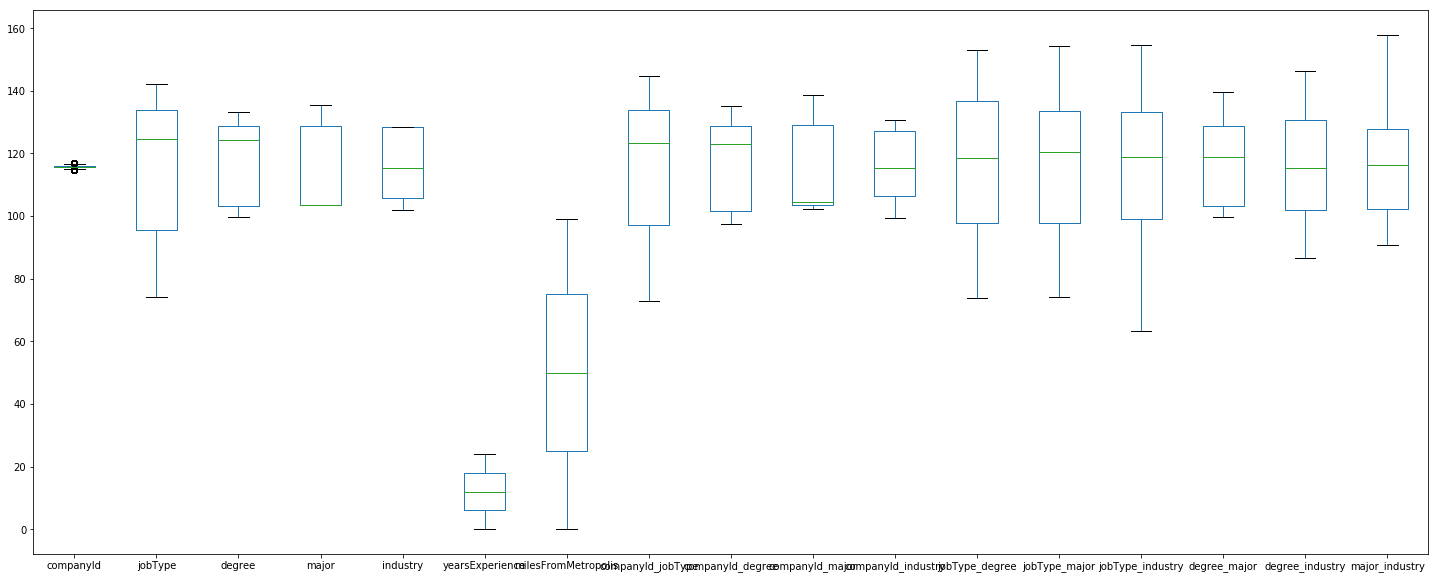

In [49]:
testdf.plot(kind='box',figsize=(25,10))

In [31]:
y_test_submit = svm_reg_final.predict(xtestpolyss)

In [32]:
pd.DataFrame(y_test_submit).describe()

,0
count,1000000.000000
mean,115.625293
std,32.761325
min,20.253883
25%,93.251044
50%,116.949169
75%,138.793073
max,226.970467


In [38]:
df2submit = pd.DataFrame({'jobId':testdf1.jobId,'salary':y_test_submit})

In [34]:
testdf1 = pd.read_csv('data/test_features_2013-03-07.csv')


In [50]:
df2submit.to_csv('test_salaries.csv',index=False)

In [47]:
# train/validation graph
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, 3000,1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
#         print(train_errors,val_errors)
        
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown


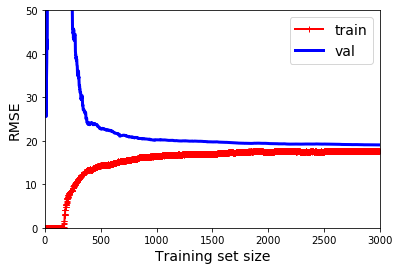

In [48]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, xtrpolyss, ytrain1)
plt.axis([0, 3000, 0, 50])                         # not shown in the book
plt.show()          